In [3]:
! pip install -q optuna catboost ppscore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [41]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
import seaborn as sns
from typing import Tuple, Dict, List
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch import nn
import ppscore as pps

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
data = pd.read_csv('train.csv')[:100000]
_ = data.pop('id')
test = pd.read_csv('test.csv')
test_id = test.pop('id')

In [ ]:
# No row has more than 1 na! For this reason we might consider to keep all features
print(data.shape)
print(data.dropna(thresh = 2).shape)

In [ ]:
data.shape

(10000, 21)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   class                 100000 non-null  object 
 1   cap-diameter          100000 non-null  float64
 2   cap-shape             99999 non-null   object 
 3   cap-surface           78308 non-null   object 
 4   cap-color             100000 non-null  object 
 5   does-bruise-or-bleed  100000 non-null  object 
 6   gill-attachment       83253 non-null   object 
 7   gill-spacing          59767 non-null   object 
 8   gill-color            100000 non-null  object 
 9   stem-height           100000 non-null  float64
 10  stem-width            100000 non-null  float64
 11  stem-root             11527 non-null   object 
 12  stem-surface          36525 non-null   object 
 13  stem-color            100000 non-null  object 
 14  veil-type             5092 non-null    object 
 15  v

In [ ]:
data['spore-print-color'].value_counts()

spore-print-color
k    3382
p    2147
w    1616
n     695
r     256
u     231
g     122
f       2
t       1
d       1
Name: count, dtype: int64

In [ ]:
data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
data.describe()

,cap-diameter,stem-height,stem-width
count,3.116941e+06,3.116945e+06,3.116945e+06
mean,6.309848e+00,6.348333e+00,1.115379e+01
std,4.657931e+00,2.699755e+00,8.095477e+00
min,3.000000e-02,0.000000e+00,0.000000e+00
25%,3.320000e+00,4.670000e+00,4.970000e+00
50%,5.750000e+00,5.880000e+00,9.650000e+00
75%,8.240000e+00,7.410000e+00,1.563000e+01
max,8.067000e+01,8.872000e+01,1.029000e+02


In [ ]:
pps_matrix = pps.matrix(data)

In [ ]:
pps_matrix

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,class,class,1.000000e+00,predict_itself,True,None,0.000000,1.000000,None
1,class,cap-diameter,8.211288e-03,regression,True,mean absolute error,3.063426,3.038271,DecisionTreeRegressor()
2,class,cap-shape,1.445699e-07,classification,True,weighted F1,0.292841,0.292841,DecisionTreeClassifier()
3,class,cap-surface,0.000000e+00,classification,True,weighted F1,0.126600,0.115929,DecisionTreeClassifier()
4,class,cap-color,1.106224e-07,classification,True,weighted F1,0.259215,0.259215,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
436,season,has-ring,0.000000e+00,classification,True,weighted F1,0.646631,0.646631,DecisionTreeClassifier()
437,season,ring-type,1.634882e-07,classification,True,weighted F1,0.763295,0.763295,DecisionTreeClassifier()
438,season,spore-print-color,1.949196e-02,classification,True,weighted F1,0.273600,0.287759,DecisionTreeClassifier()
439,season,habitat,1.148577e-07,classification,True,weighted F1,0.572028,0.572028,DecisionTreeClassifier()


Text(0.5, 1.0, 'Predictive Power Score (PPS) Matrix')

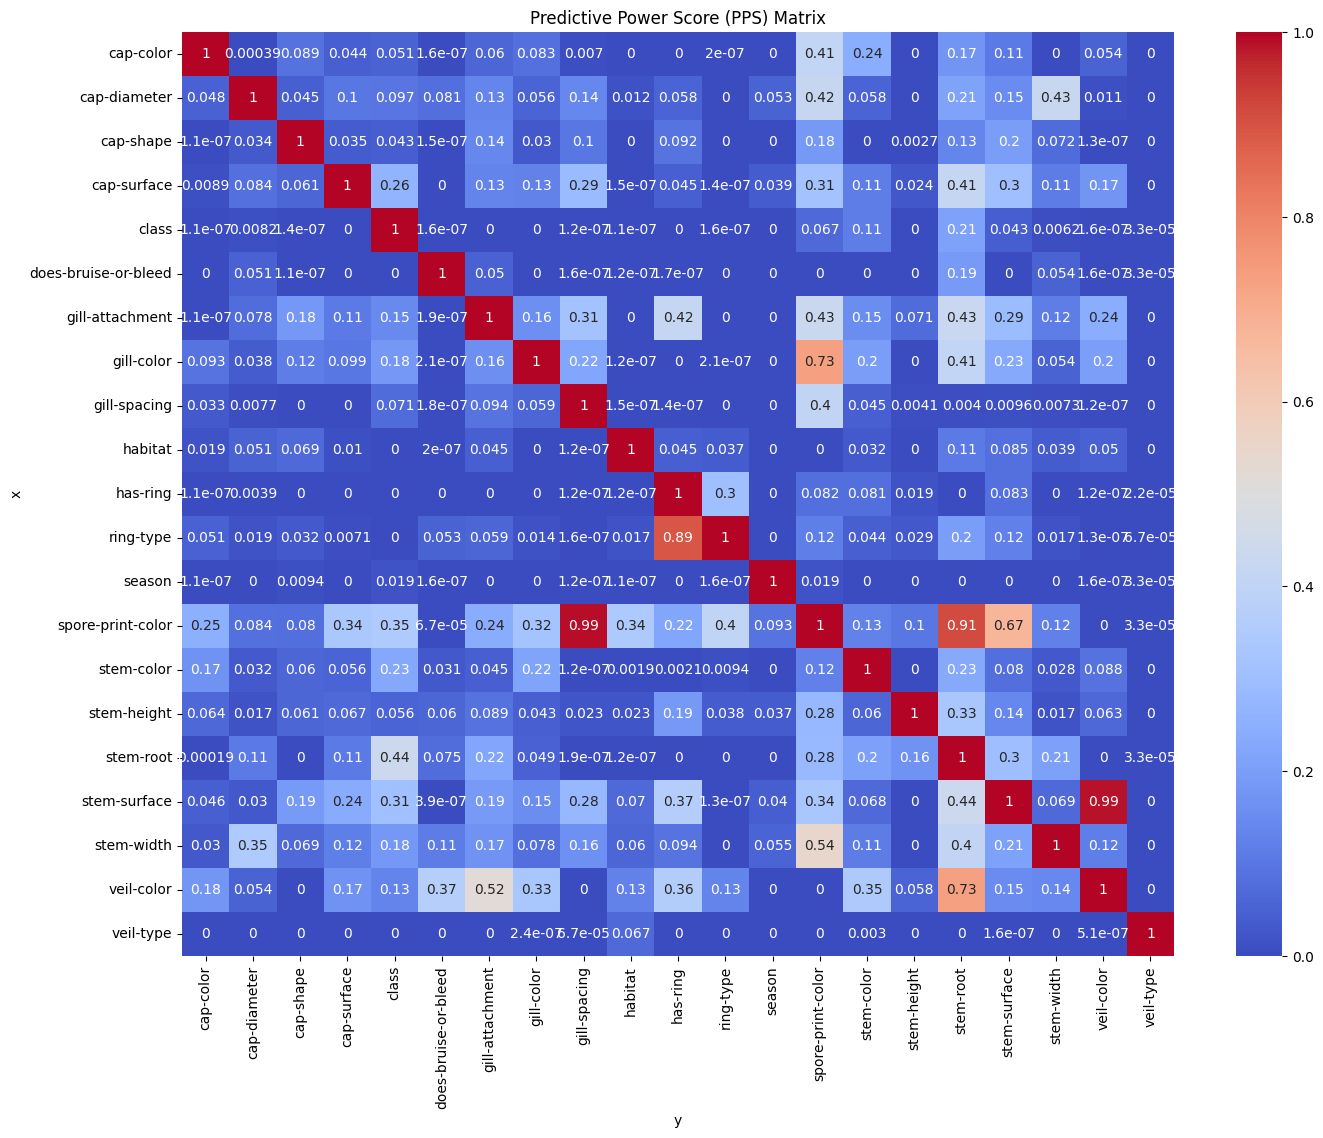

In [ ]:
pps_df = pps_matrix.pivot(index='x', columns='y', values='ppscore')
plt.figure(figsize=(16,12))
sns.heatmap(pps_df, annot=True, cmap='coolwarm', cbar=True, vmin=0, vmax=1)
plt.title('Predictive Power Score (PPS) Matrix')

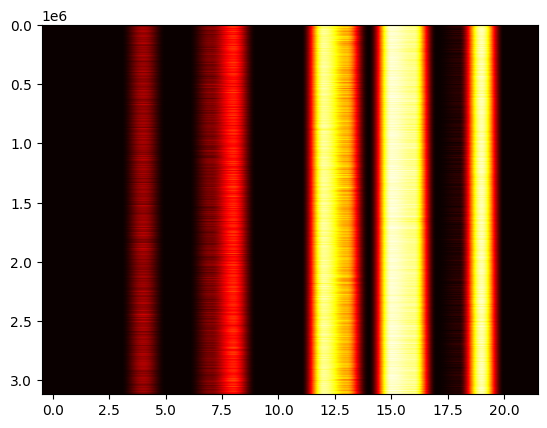

In [ ]:
plt.imshow(data.isnull(), cmap = 'hot', aspect = 'auto')

In [ ]:
# @title Percentage of missing values per feature
percentage_nan_features = data.isnull().sum()/data.shape[0]
percentage_nan_features

class                   0.00000
cap-diameter            0.00000
cap-shape               0.00001
cap-surface             0.21692
cap-color               0.00000
does-bruise-or-bleed    0.00000
gill-attachment         0.16747
gill-spacing            0.40233
gill-color              0.00000
stem-height             0.00000
stem-width              0.00000
stem-root               0.88473
stem-surface            0.63475
stem-color              0.00000
veil-type               0.94908
veil-color              0.88042
has-ring                0.00000
ring-type               0.04071
spore-print-color       0.91547
habitat                 0.00001
season                  0.00000
dtype: float64

**How useful are features with high % of missing values?**
A model performs notably better if all the features are kept, thus implictly saying that these yield a great value.
At this point we could ask how to fill those missing values: for example by using the most common entrance, the
property of a row not having NaN for that feature could be lost. That is: there's an importance in not having NaN.
To dig into this let's see if values in features with high % of NaN are strong predictors (spoiler: yes, from pps score)

In [ ]:
empty_features = percentage_nan_features.index[percentage_nan_features>0.4].tolist()

In [ ]:
empty_features.remove('gill-spacing')

In [ ]:
def print_poisonous_percentage(col, unique_val):
    n_rows = data[data[col] == unique_val].shape[0]
    print(f"Rows with value of {unique_val}:", n_rows)
    print("Edible %:", round(data[data[col] == unique_val]["class"].value_counts(True).iloc[0], 3))
    print("Posionous %:", round(data[data[col] == unique_val]["class"].value_counts(True).iloc[1], 3))
    print()
    return n_rows

def print_vals(col, vals):
    n_rows = 0
    for val in vals:
        n_rows += print_poisonous_percentage(col = col, unique_val = val)
    print("Total rows:", n_rows)


In [ ]:
n_rows = data.shape[0]

for feature in empty_features:
    print(feature)
    value_percentage = data[feature].value_counts()/n_rows
    vals = value_percentage.index[value_percentage>0.001].tolist()
    print_vals(col = feature, vals = vals)
    print('---------------------------------')

stem-root
Rows with value of b: 165801
Edible %: 0.648
Posionous %: 0.352

Rows with value of s: 116946
Edible %: 0.699
Posionous %: 0.301

Rows with value of r: 47803
Edible %: 0.995
Posionous %: 0.005

Rows with value of c: 28592
Edible %: 0.996
Posionous %: 0.004

Total rows: 359142
---------------------------------
stem-surface
Rows with value of s: 327610
Edible %: 0.604
Posionous %: 0.396

Rows with value of y: 255500
Edible %: 0.701
Posionous %: 0.299

Rows with value of i: 224346
Edible %: 0.639
Posionous %: 0.361

Rows with value of t: 147974
Edible %: 0.541
Posionous %: 0.459

Rows with value of g: 78080
Edible %: 0.996
Posionous %: 0.004

Rows with value of k: 73383
Edible %: 0.698
Posionous %: 0.302

Rows with value of h: 28283
Edible %: 0.996
Posionous %: 0.004

Total rows: 1135176
---------------------------------
veil-type
Rows with value of u: 159373
Edible %: 0.656
Posionous %: 0.344

Total rows: 159373
---------------------------------
veil-color
Rows with value of w:

Since the dataset isn't highly imbalanced, I'll proceed in the following way:
1. If a column doesn't have a high % Nan, fill it in the usual way
2. Else we can try two methods:
    - the most common class isn't a strong indicator, thus assigning it to NaN won't disrupt the distribution
    - the most common class is a strong indicator and assigning it to NaN would disrupt this power. So I could assign to NaN an "other" class

In [52]:
strong_indicator_features = ['spore-print-color', 'veil-type', 'stem-surface', 'stem-root']

In [ ]:
def plot_histograms(df: pd.DataFrame,
                    threshold: int = 10) -> Tuple[List[str], List[str]]:
    """Plot the distribution of each feature and categorize it as continuous or categorical

    The threshold is an hyperparameter that can be tweaked to look at how results change

    Args:
        df (pd.DataFrame): dataframe containing the data on which we work on
        threshold (int): if a feature has > threshold values then it's continuous

    Returns:
        Tuple[List[str], List[str]]: (list_of_con_features, list_of_cat_features)

    Example:
        plot_histograms(data, 10)
        >>> (['height', 'weight'], ['name', 'sex'])
    """
    cat_columns = []
    con_columns = []

    for column in df.columns:
        unique_values = df[column].nunique()
        plt.figure(figsize=(8, 4))

        if df[column].dtype in ['int64', 'float64']:
            if unique_values <= threshold:
                cat_columns.append(column)
                plt.hist(df[column], bins=unique_values, color='skyblue', edgecolor='black')
                plt.title(f"Categorical Histogram of '{column}'")
            else:
                con_columns.append(column)
                plt.hist(df[column], bins=10, color='skyblue', edgecolor='black')
                plt.title(f"Continuous Histogram of '{column}'")
        else:
            cat_columns.append(column)
            df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
            plt.title(f"Categorical Histogram of '{column}'")

        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
    return con_columns, cat_columns

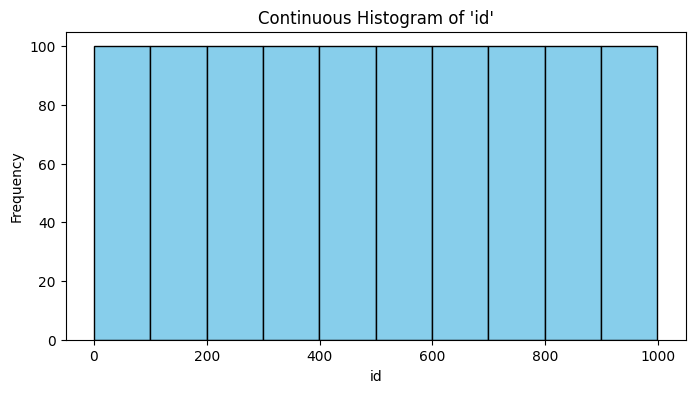

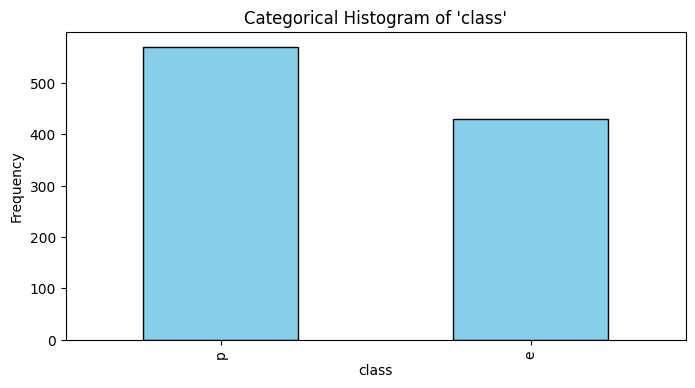

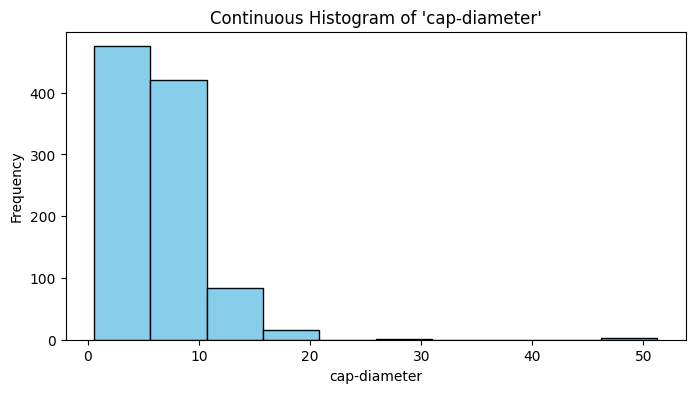

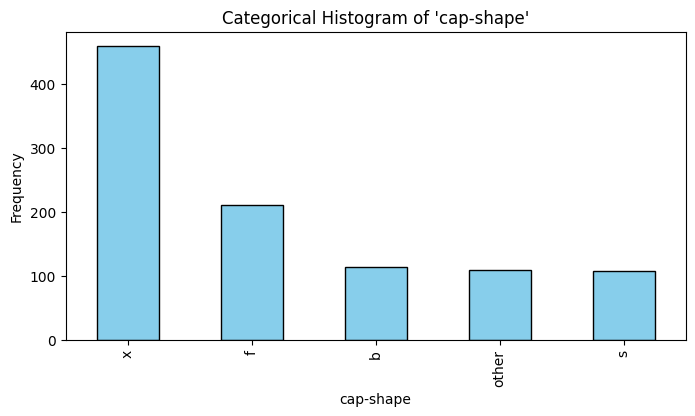

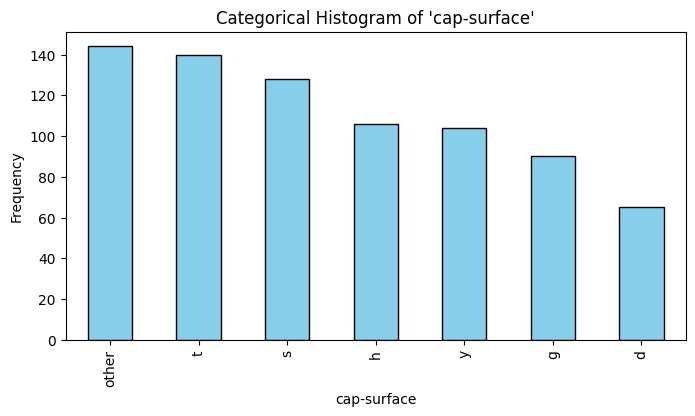

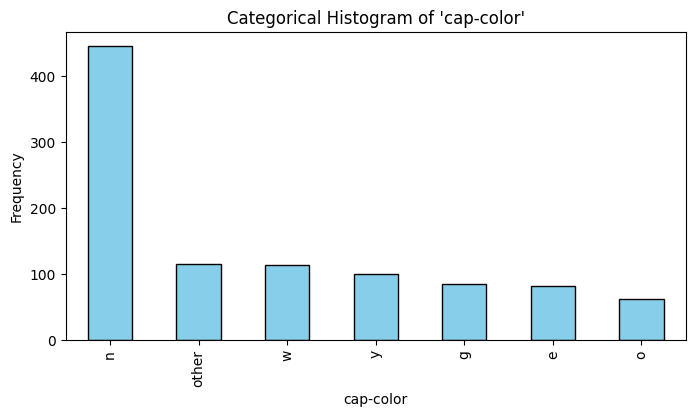

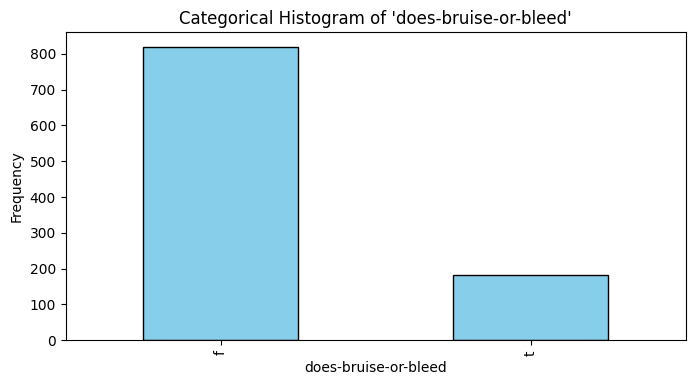

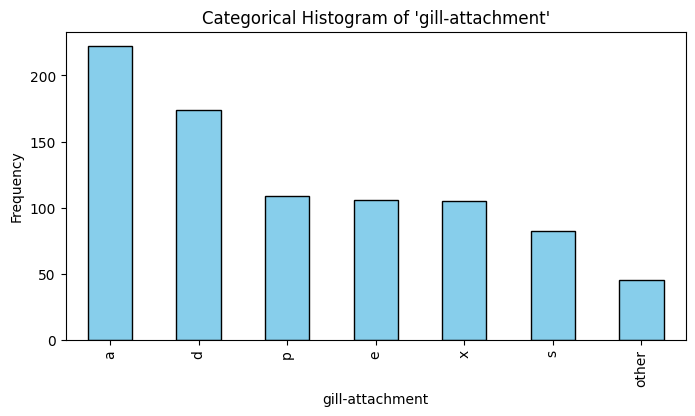

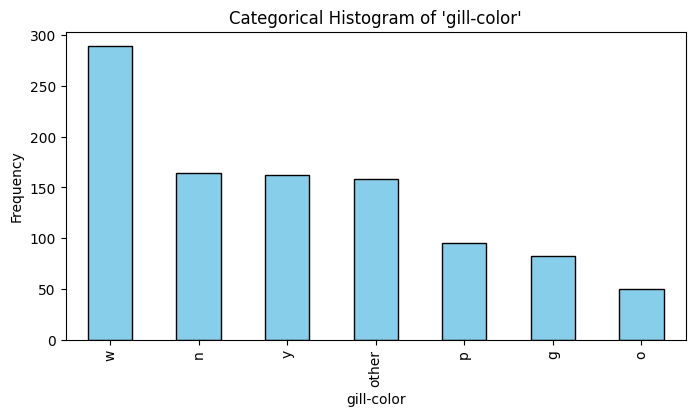

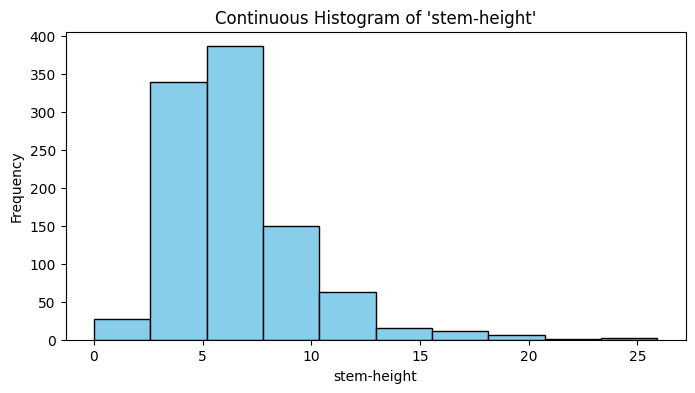

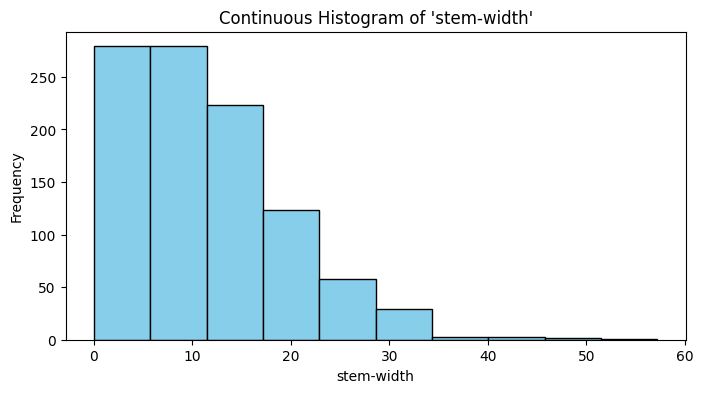

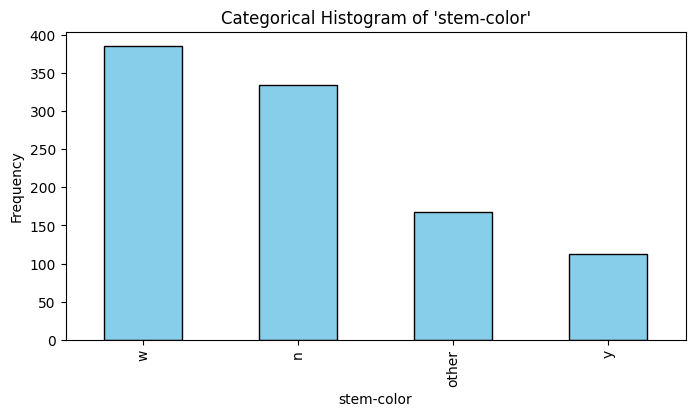

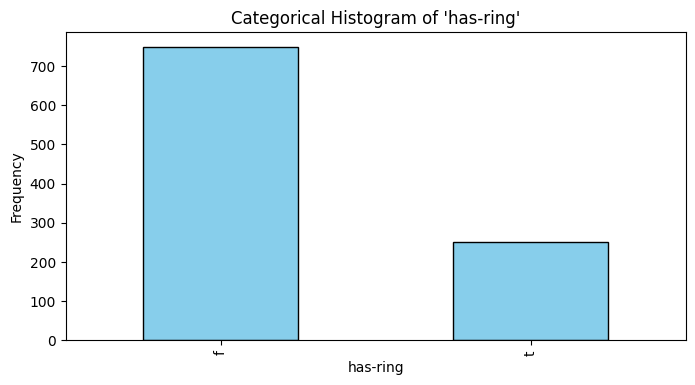

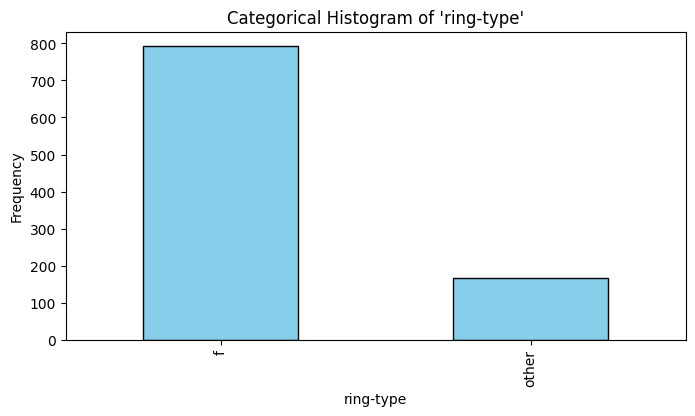

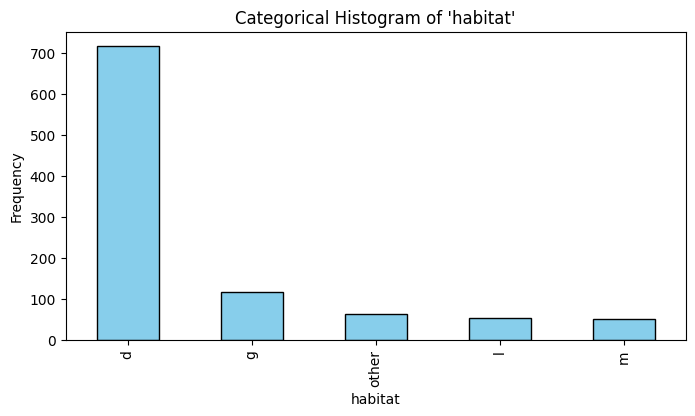

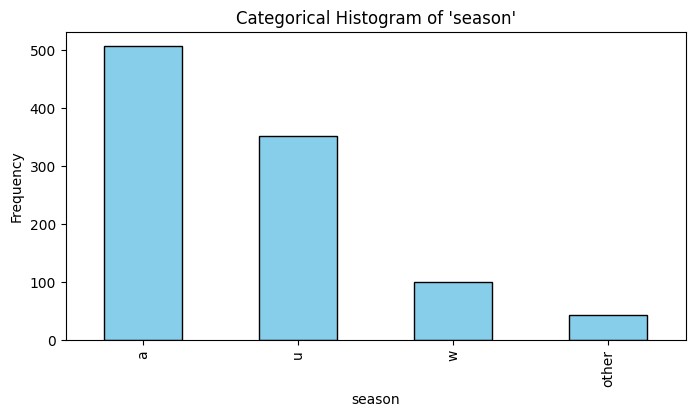

In [ ]:
con_columns, cat_columns = plot_histograms(data)

In [43]:
def get_cat_con_columns(data, threshold):
    cat_columns = []
    con_columns = []
    for column in data.columns:
        unique_values = data[column].nunique()

        if data[column].dtype in ['int64', 'float64']:
            if unique_values <= threshold:
                cat_columns.append(column)
            else:
                con_columns.append(column)
        else:
            cat_columns.append(column)
    return cat_columns, con_columns

In [44]:
def group_rare_values(data, cat_columns, threshold_percentage):

    # Calculate the threshold count
    total_count = len(data)
    threshold_count = total_count * (threshold_percentage / 100)

    for feature in cat_columns:
        # Calculate frequency of each category
        category_counts = data[feature].value_counts()

        # Identify categories that appear less frequently than the threshold
        rare_categories = category_counts[category_counts < threshold_count].index

        # Replace rare categories with 'other'
        data[feature] = data[feature].replace(rare_categories, 'other')
    return data

In [45]:
def drop_columns(X, test, threshold):
    # Calculate the percentage of missing values for each column
    missing_percentage = X.isnull().mean() * 100
    # Identify columns to drop
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    X = X.drop(columns=columns_to_drop)

    test = test.drop(columns = columns_to_drop)

    return X, test

In [46]:
def cleaning_pipeline(data, test):

    X = data.drop('class', axis=1)
    y = data['class'].map({'e':0, 'p':1}).astype(int)

    X, test= drop_columns(X, test, 100) # 100 = no column deleted

    cat_columns, con_columns = get_cat_con_columns(X, 10)

    X = group_rare_values(X, cat_columns, 0.01)
    test = group_rare_values(test, cat_columns, 0.01)

    for feature in strong_indicator_features:
        X[feature] = X[feature].fillna('other')
        test[feature] = test[feature].fillna('other')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    numeric_transformer = Pipeline(steps=[
        ('imputer',  KNNImputer(n_neighbors=5)),  # Fill missing values with mean
        ('scaler', StandardScaler())  # Standardize the numeric columns
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with the most frequent value
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot encode categorical columns
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, con_columns),
            ('cat', categorical_transformer, cat_columns)
        ])

    # Fit the preprocessor to the training data and transform it
    X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train).toarray())
    X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test).toarray())
    test = pd.DataFrame(preprocessor.transform(test).toarray())

    return X_train_preprocessed, X_test_preprocessed, y_train, y_test, test

In [47]:
def prepare_full_dataset():
    data = pd.read_csv('train.csv')
    _ = data.pop('id')
    test = pd.read_csv('test.csv')
    test_id = test.pop('id')

    return *cleaning_pipeline(data, test), test_id

In [48]:
def kaggle_predictions(model, X_train, y_train, X_test, y_test, test_id, model_name):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print classification report
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(report)

    predictions = model.predict(test)
    predictions = ['e' if pred == 0 else 'p' for pred in predictions]

    df = pd.DataFrame({
        'id': test_id,
        'predictions': predictions
    })
    df.to_csv(f'predictions_{model_name}.csv', index=False)


In [97]:
def optuna_optimization(objective, n_trials = 50):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials = n_trials)  # Number of trials can be adjusted

    # Print the best parameters and best F1 score
    print("Best parameters found: ", study.best_params)
    print("Best cross-validation F1 score: {:.2f}".format(study.best_value))

    return study.best_params

In [53]:
X_train, X_test, y_train, y_test, test = cleaning_pipeline(data, test)

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,-0.609244,-0.515837,-0.717873,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.424426,0.055967,-0.445699,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.207397,3.683576,0.835115,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.776871,0.378998,-1.073791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.041205,-0.597523,-1.168621,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 components for 2D plot
pca_result = pca.fit_transform(X_train)


In [ ]:
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


In [ ]:
pca_df.head()

,PC1,PC2
0,-1.332334,-0.082205
1,-0.642447,0.224041
2,2.202471,2.366298
3,-1.091340,0.703764
4,-1.781709,0.020975


In [ ]:
pca_df['Label'] = y_train

In [ ]:
pca_df.head()

,PC1,PC2,Label
0,-1.332334,-0.082205,0.0
1,-0.642447,0.224041,1.0
2,2.202471,2.366298,0.0
3,-1.091340,0.703764,0.0
4,-1.781709,0.020975,0.0


In [58]:
!mkdir optuna_objective

In [67]:
%%writefile optuna_objective/rf.py

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def get_objective(X_train, y_train):

    def objective(trial):
        # Define the hyperparameters to optimize
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        # Initialize Random Forest with suggested hyperparameters
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

        # Setup StratifiedKFold cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        f1_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]


            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            score = f1_score(y_test_fold, y_pred, average='weighted')  # Using weighted F1 score
            f1_scores.append(score)

        return np.mean(f1_scores)

    return objective

Overwriting optuna_objective/rf.py


In [73]:
%%writefile optuna_objective/xgb.py

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def get_objective(X_train, y_train):

    def objective(trial):
        # Define the hyperparameter search space
        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'verbosity': 0,
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        }

        # Train the model
        model = XGBClassifier(**param, use_label_encoder=False)

        # Use cross-validation to evaluate the performance
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs= -1).mean()

        return score

    return objective


Writing optuna_objective/xgb.py


In [83]:
%%writefile optuna_objective/cat.py

from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

def get_objective(X_train, y_train):

    def objective(trial):
        # Define the hyperparameters to optimize
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_loguniform('random_strength', 1e-5, 10),
            'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100),
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait': trial.suggest_int('od_wait', 10, 50)
        }

        # Initialize the CatBoost model with the current hyperparameters
        model = CatBoostClassifier(**params, verbose=0)

        # Perform cross-validation and return the mean accuracy
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs = -1)
        return scores.mean()

        # Create the Optuna study and optimize the objective function

    return objective

Overwriting optuna_objective/cat.py


In [87]:
from optuna_objective import rf, cat, xgb

In [ ]:
objective = rf.get_objective(X_train, y_train)
best_params = optuna_optimization(objective)

In [ ]:
data = pd.read_csv('train.csv')
_ = data.pop('id')
test = pd.read_csv('test.csv')
test_id = test.pop('id')

X_train, X_test, y_train, y_test, test = cleaning_pipeline(data, test)

In [ ]:
model = RandomForestClassifier(**best_params, random_state=42, n_jobs = -1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print classification report
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    282397
           1       0.99      0.99      0.99    340992

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389



In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(xgb.get_objective(X_train, y_train), n_trials=50, n_jobs= -1)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-26 11:32:23,584] A new study created in memory with name: no-name-1bee7695-46e8-4333-b5dc-7b3524245d06
[I 2024-08-26 11:32:36,735] Trial 0 finished with value: 0.989114749668073 and parameters: {'n_estimators': 644, 'max_depth': 6, 'learning_rate': 0.17525085466835294, 'subsample': 0.8632010358900502, 'colsample_bytree': 0.7781407692328216, 'gamma': 3.5630980212547265, 'min_child_weight': 2, 'lambda': 0.00024306277289374477, 'alpha': 0.00021245714314921448}. Best is trial 0 with value: 0.989114749668073.
[I 2024-08-26 11:32:44,687] Trial 3 finished with value: 0.9891806129605157 and parameters: {'n_estimators': 528, 'max_depth': 9, 'learning_rate': 0.030315692250152546, 'subsample': 0.7843312358441935, 'colsample_bytree': 0.9390084372858614, 'gamma': 3.657955906541095, 'min_child_weight': 3, 'lambda': 0.0005600703355022141, 'alpha': 1.1171764639966765e-06}. Best is trial 3 with value: 0.9891806129605157.
[I 2024-08-26 11:32:48,091] Trial 4 finished with value: 0.919215091899

Best trial:
  Value: 0.9909
  Params: 
    n_estimators: 690
    max_depth: 10
    learning_rate: 0.1369247136675448
    subsample: 0.699990541121843
    colsample_bytree: 0.5735486457386931
    gamma: 1.4574669345424744
    min_child_weight: 2
    lambda: 0.0008426154730457521
    alpha: 1.3330718692004976e-05


In [ ]:
params = {'n_estimators': 690, 'max_depth': 10, 'learning_rate': 0.1369247136675448, 'subsample': 0.699990541121843, 'colsample_bytree': 0.5735486457386931, 'gamma': 1.4574669345424744, 'min_child_weight': 2, 'lambda': 0.0008426154730457521, 'alpha': 1.3330718692004976e-05}
X_train, X_test, y_train, y_test, test, test_id = prepare_full_dataset()
xgb = XGBClassifier(**params, random_state=42, n_jobs = -1)
kaggle_predictions(xgb, X_train, y_train, X_test, y_test, test_id, 'xgb')

Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    141239
           1       0.99      0.99      0.99    170456

    accuracy                           0.99    311695
   macro avg       0.99      0.99      0.99    311695
weighted avg       0.99      0.99      0.99    311695



In [ ]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.9914
  Params: 
    iterations: 828
    depth: 9
    learning_rate: 0.046191970873865784
    l2_leaf_reg: 0.10611258486150435
    border_count: 48
    random_strength: 0.0016875217947282832
    bagging_temperature: 0.29290849458897616
    od_type: IncToDec
    od_wait: 14


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(cat.get_objective(X_train, y_train), n_trials=50, n_jobs= -1)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
model = CatBoostClassifier(**study.best_params, random_state=42)
kaggle_predictions(model, X_train, y_train, X_test, y_test, test_id, 'cat')

0:	learn: 0.6420342	total: 214ms	remaining: 2m 57s
1:	learn: 0.5983571	total: 352ms	remaining: 2m 25s
2:	learn: 0.5695354	total: 521ms	remaining: 2m 23s
3:	learn: 0.5336258	total: 659ms	remaining: 2m 15s
4:	learn: 0.5063895	total: 789ms	remaining: 2m 9s
5:	learn: 0.4848226	total: 916ms	remaining: 2m 5s
6:	learn: 0.4628677	total: 1.05s	remaining: 2m 2s
7:	learn: 0.4414990	total: 1.18s	remaining: 2m
8:	learn: 0.4296597	total: 1.31s	remaining: 1m 58s
9:	learn: 0.4151929	total: 1.44s	remaining: 1m 57s
10:	learn: 0.4026471	total: 1.57s	remaining: 1m 56s
11:	learn: 0.3869179	total: 1.7s	remaining: 1m 55s
12:	learn: 0.3693460	total: 1.83s	remaining: 1m 55s
13:	learn: 0.3537899	total: 1.97s	remaining: 1m 54s
14:	learn: 0.3420166	total: 2.1s	remaining: 1m 53s
15:	learn: 0.3299372	total: 2.23s	remaining: 1m 53s
16:	learn: 0.3196886	total: 2.36s	remaining: 1m 52s
17:	learn: 0.3108231	total: 2.49s	remaining: 1m 51s
18:	learn: 0.3023220	total: 2.61s	remaining: 1m 51s
19:	learn: 0.2927479	total: 2.7

Ensemble Learning

In [ ]:
params = {'n_estimators': 690, 'max_depth': 10, 'learning_rate': 0.1369247136675448, 'subsample': 0.699990541121843, 'colsample_bytree': 0.5735486457386931, 'gamma': 1.4574669345424744, 'min_child_weight': 2, 'lambda': 0.0008426154730457521, 'alpha': 1.3330718692004976e-05}
xgb = XGBClassifier(**params, random_state=42, n_jobs = -1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_2 = model.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_pred, y_test), f1_score(y_pred_2, y_test)

(0.9925185128635774, 0.9922425993458179)

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
data = pd.concat([pd.Series(y_pred), pd.Series(y_pred_2)], axis=1)

In [ ]:
models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(), GaussianNB(), MultinomialNB(), BernoulliNB()]
for clf in models:
    name = clf.__class__.__name__
    acc = cross_val_score(clf, data, y_test, cv=5, scoring='f1').mean()
    print(name,acc)

LogisticRegression 0.9925184961382401
RandomForestClassifier 0.9925184961382401
XGBClassifier 0.9925184961382401
GaussianNB 0.9923598234215696
MultinomialNB 0.707064799179663
BernoulliNB 0.9923598234215696


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

# Add layers to the model
model.add(Dense(256, input_dim=2, activation='relu'))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dropout(0.2))  # Add Dropout with 50% dropout rate
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dropout(0.2))  # Add Dropout with 50% dropout rate
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Add Batch Normalization
model.add(Dropout(0.2))  # Add Dropout with 50% dropout rate
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(data, y_test,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50
488/488 [==============================] - 2s 3ms/step - loss: 0.0526 - accuracy: 0.9898 - val_loss: 0.0508 - val_accuracy: 0.9916
Epoch 2/50
488/488 [==============================] - 1s 3ms/step - loss: 0.0473 - accuracy: 0.9917 - val_loss: 0.0471 - val_accuracy: 0.9916
Epoch 3/50
488/488 [==============================] - 2s 3ms/step - loss: 0.0466 - accuracy: 0.9918 - val_loss: 0.0472 - val_accuracy: 0.9914
Epoch 4/50
488/488 [==============================] - 2s 4ms/step - loss: 0.0466 - accuracy: 0.9918 - val_loss: 0.0467 - val_accuracy: 0.9916
Epoch 5/50
488/488 [==============================] - 1s 3ms/step - loss: 0.0464 - accuracy: 0.9918 - val_loss: 0.0468 - val_accuracy: 0.9916
Epoch 6/50
488/488 [==============================] - 2s 3ms/step - loss: 0.0462 - accuracy: 0.9918 - val_loss: 0.0473 - val_accuracy: 0.9916
Epoch 7/50
488/488 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9918 - val_loss: 0.0466 - val_accuracy: 0.9916
Epoch 

KeyboardInterrupt: 

In [ ]:
final_model = RandomForestClassifier()
final_model.fit(data, y_test)


In [ ]:

X_kaggle = pd.concat([pd.read_csv('predictions.csv')['predictions'].map({'e':0, 'p':1}).astype(int), pd.read_csv('predictions2.csv')['predictions'].map({'e':0, 'p':1}).astype(int)], axis=1)

In [ ]:
X_kaggle.head()

,predictions,predictions
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0


In [ ]:
predictions = model.predict(X_kaggle)


64937/64937 [==============================] - 17s 254us/step


In [ ]:
predictions = ['e' if pred == 0 else 'p' for pred in predictions.round()]

df = pd.DataFrame({
    'id': test_id,
    'predictions': predictions
})
df.to_csv('predictions2.csv', index=False)

In [ ]:
differing_values = predictions != pd.read_csv('predictions.csv')['predictions']

# Step 3: Count the number of differing values
differing_values.sum()


944901

In [ ]:
X_train_tensor = torch.Tensor(X_train.to_numpy())
y_train_tensor = torch.Tensor(y_train.to_numpy()).unsqueeze(dim=-1)

In [ ]:
X_test_tensor = torch.Tensor(X_test.to_numpy())
y_test_tensor = torch.Tensor(y_test.to_numpy()).unsqueeze(dim=-1)

In [ ]:
# Concatenate along the columns (dim=1)
train_tensor = torch.cat((X_train_tensor, y_train_tensor), dim=1)

In [ ]:
train_tensor[0]

tensor([-0.6092, -0.5158, -0.7179,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
train_tensor.shape

torch.Size([90000, 115])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 50)
        self.dropout1 = nn.Dropout(0.7)
        self.fc2 = nn.Linear(50, 40)
        self.dropout2 = nn.Dropout(0.65)
        self.fc3 = nn.Linear(40, 20)
        self.dropout3 = nn.Dropout(0.6)
        self.fc4 = nn.Linear(20, 10)
        self.dropout4 = nn.Dropout(0.55)
        self.fc5 = nn.Linear(10, 5)
        self.dropout5 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.dropout2(x)
        x = nn.functional.leaky_relu(self.fc3(x))
        x = self.dropout3(x)
        x = nn.functional.leaky_relu(self.fc4(x))
        x = self.dropout4(x)
        x = nn.functional.leaky_relu(self.fc5(x))
        x = self.dropout5(x)
        x = self.sigmoid(self.fc6(x))
        return x

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
trainDataLoader = DataLoader(trainDataset, batch_size = 32, shuffle = True)

testDataset = TensorDataset(X_test_tensor, y_test_tensor)
testDataLoader = DataLoader(testDataset, batch_size = 64)

In [ ]:
epochs = 100

model = NN()
loss_fn = nn.BCEWithLogitsLoss() # BCE + Sigmoid
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
    for xb, yb in trainDataLoader:
        model.train()

        y_logits = model(xb)
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

        loss = loss_fn(y_logits, yb)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # How's the train loss calculated per epoch? as average of the batches?
    model.eval()
    with torch.inference_mode():
        valid_loss = sum(loss_fn(model(xb), yb) for xb, yb in testDataLoader) # here should be the validation set
        test_acc = sum(accuracy_fn(yb, model(xb)) for xb, yb in testDataLoader)/len(testDataLoader)
    print(f"Epoch: {epoch} | Test loss: {valid_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Test loss: 84.37278, Test acc: 25.50%
Epoch: 1 | Test loss: 82.89167, Test acc: 55.87%
Epoch: 2 | Test loss: 82.53099, Test acc: 84.95%
Epoch: 3 | Test loss: 83.27161, Test acc: 87.73%
Epoch: 4 | Test loss: 82.40543, Test acc: 89.15%
Epoch: 5 | Test loss: 81.78889, Test acc: 90.55%
Epoch: 6 | Test loss: 81.29866, Test acc: 91.58%
Epoch: 7 | Test loss: 81.38438, Test acc: 91.50%
Epoch: 8 | Test loss: 80.95549, Test acc: 92.19%
Epoch: 9 | Test loss: 81.02606, Test acc: 91.94%
Epoch: 10 | Test loss: 80.74971, Test acc: 92.46%
Epoch: 11 | Test loss: 80.50137, Test acc: 92.99%
Epoch: 12 | Test loss: 80.26128, Test acc: 93.80%
Epoch: 13 | Test loss: 80.46178, Test acc: 93.31%
Epoch: 14 | Test loss: 80.63194, Test acc: 92.93%
Epoch: 15 | Test loss: 80.11063, Test acc: 94.15%
Epoch: 16 | Test loss: 80.63245, Test acc: 92.72%
Epoch: 17 | Test loss: 80.41374, Test acc: 93.51%
Epoch: 18 | Test loss: 80.05271, Test acc: 93.81%
Epoch: 19 | Test loss: 80.23922, Test acc: 93.77%
Epoch: 20 

KeyboardInterrupt: 

In [ ]:
len(testDataLoader)

157

In [ ]:
y_test_tensor.shape

torch.Size([10000, 1])

In [ ]:
157*64

10048